In [1]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
#sys.path.append("/home/tinkerer/Poisson/")

import numpy as np
from collections import OrderedDict
from ccode.plotting import plot_gates
from ccode.gates import rectangular_gate, half_disk_gate
from ccode.finite_system import finite_system
import ccode.parameters as pm
import ccode.solvers as sl
import ccode.tools as tl
import itertools as it
import dask.bag as db
from scipy import constants
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options

import poisson
import kwant
from potential import gate_potential, linear_problem_instance
from plotting import plot_potential
from Hamiltonian import discrete_system_coordinates

from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    TwoDEGLayer,
)

from itertools import product
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
a = 10e-9

In [3]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/srangaswamykup/trijunction_design/"

# Y-shaped geometry

#### Parameters

In [4]:
thickness_dielectric = 1
thickness_twoDEG = 1
thickness_gates = 3

grid_spacing_twoDEG = 0.5
grid_spacing_normal = 1
grid_spacing_dielectric = 1
grid_spacing_air = 5
grid_spacing_gate = grid_spacing_twoDEG

permittivity_metal = 5000
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

In [5]:
# one only needs to define the arm length L, and the channel width
L = 41
width = 12
gap = 4

R = L/np.sqrt(2)

In [6]:
R

28.991378028648448

In [7]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R
xmin = -xmax
ymin = 0
ymax = R + L - width
total_width = 2*xmax
total_length = ymax

#### Make gate polygons using Shapely

In [8]:
Y = unary_union(
    (
        Polygon(half_disk_gate(R=R, npts=3)).difference(Polygon(half_disk_gate(R=R-width*np.sqrt(2), npts=3))),
        Polygon(rectangular_gate(center=(0,R+L/2-width), width=width, length=L))
    )
)

gates = Polygon(rectangular_gate(center=(0, (R+L-width)/2), length=R+L-width-1,width=2*R)).difference(Y)

aux_rectangle_1 = rectangular_gate(length=R+2*gap, width=R+gap, center=(R/2, R/2-width/2))
aux_rectangle_2 = rectangular_gate(length=R+2*gap, width=R+gap, center=(-R/2, R/2-width/2))


def gate_coords(obj, difference=None, common=None, gap=None):

    if type(common) == np.ndarray:
        return np.round(np.array(list(obj.intersection(Polygon(common)).exterior.coords)), 2)

    else:
        if gap is not None:
            return np.round(np.array(list(obj.difference(Polygon(difference).buffer(gap)).exterior.coords)), 2)
        else:
            return np.round(np.array(list(obj.difference(Polygon(difference)).exterior.coords)), 2)


gates_vertex = [gate_coords(gates[0], common = aux_rectangle_2), 
                gate_coords(gates[2], difference = aux_rectangle_1), 
                gate_coords(gates[2], difference = aux_rectangle_2), 
                gate_coords(gates[1], common = aux_rectangle_1), 
                gate_coords(gates[0], difference = aux_rectangle_2, gap = gap), 
                gate_coords(gates[1], difference = aux_rectangle_1, gap = gap)]

gates_name = ['left_1', 'left_2', 'right_1', 'right_2', 'top_1', 'top_2']

#### Construct layout object for the Poisson solver

In [9]:
# Solve for Poisson system

layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    SimpleChargeLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer=False,
        fix_overlap=False,
        z_bottom=None
    ),
    center=True,
)

height = thickness_twoDEG / 2

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3",
        thickness_dielectric,
        permittivity_Al2O3,
        grid_spacing_dielectric,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    )
)

height += thickness_dielectric


layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name=gates_name,
                                      gate_objects=gates_vertex,
                                      remove_points=False,
                                      add_to_previous_layer=False,
                                      z_bottom=height,
                                      fix_overlap=True
                                     )
            )



In [10]:
height += thickness_gates + 1
layout.add_layer(
    SimpleChargeLayer("Al2O3_2", thickness_dielectric, permittivity_Al2O3, grid_spacing_dielectric,
                     add_to_previous_layer = False,
                     z_bottom = height, fix_overlap = False)
)

height += thickness_dielectric + 1
thickness_accumulation_gate = 2
layout.add_layer(PlanarGateLayer("global_accumul", 
                                 thickness_accumulation_gate, 
                                 permittivity_metal, 
                                 grid_spacing_gate, 
                                 gate_coords = [],
                                 second_layer = [],
                                 fix_overlap = False,
                                 z_bottom = height
                                )
                )

#### Build Poisson object

In [11]:
%%time

poisson_system = layout.build()

checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 1min 17s, sys: 4.29 s, total: 1min 21s
Wall time: 1min 21s


In [12]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

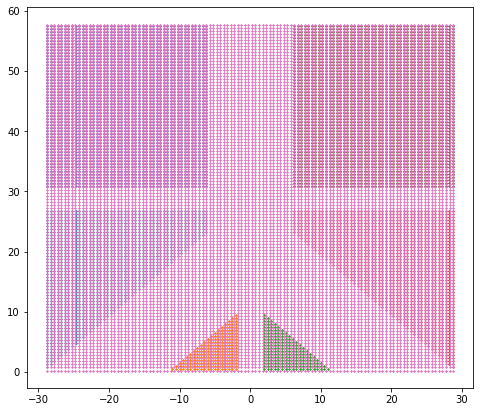

In [13]:
plt.figure(figsize = (8, 7))
for name, indices in voltage_regions.items():
    grid_to_plot = grid_points[indices][:, [0, 1]]
    plt.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)

#### LU decomposition of finite system

In [14]:
%%time

linear_problem = linear_problem_instance(poisson_system)

CPU times: user 3.39 s, sys: 185 ms, total: 3.58 s
Wall time: 3.57 s


In [15]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('charge', 'twoDEG')], boundaries=None
)

crds = site_coords[:, [0, 1]]
grid_spacing = grid_spacing_twoDEG
offset = crds[0]%grid_spacing

In [16]:
grid_points= poisson_system.grid.points

In [17]:
charge_regions = poisson_system.regions.charge.tag_points

In [18]:
voltage_regions = poisson_system.regions.voltage.tag_points
regions_to_add = []
for region in voltage_regions.keys():
    if region not in ['dirichlet_0', 'dirichlet_1', 'dirichlet_2', 'dirichlet_3']:
        regions_to_add.append(('voltage', region))
for region in charge_regions.keys():
    # if region not in ['air']:
    regions_to_add.append(('charge', region))

#### Verify the potential

In [19]:
voltage_regions = list(poisson_system.regions.voltage.tag_points.keys())

In [20]:
depleted = -1e-3
acumulate = 4e-3

def voltage_dict(depleted, acumulate):
    voltages = {}

    voltages['left_1'] = depleted
    voltages['left_2'] = depleted

    voltages['right_1'] = depleted
    voltages['right_2'] = depleted

    voltages['top_1'] = depleted
    voltages['top_2'] = depleted

    voltages['global_accumul'] = acumulate

    return voltages

In [21]:
voltages = voltage_dict(depleted, acumulate)

In [22]:
%%time

charges = {}
clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset=offset,
        grid_spacing=a
    )

CPU times: user 566 ms, sys: 3.97 ms, total: 570 ms
Wall time: 569 ms


In [23]:
coordinates = np.array(list(clean_potential.keys()))

x = coordinates[:, 0]
y = coordinates[:, 1]
width_plot = np.unique(x).shape[0]
X = x.reshape(width_plot, -1) / a
Y = y.reshape(width_plot, -1) / a
Z = np.round(np.array(list(clean_potential.values())).reshape(width_plot, -1) * -1, 4)

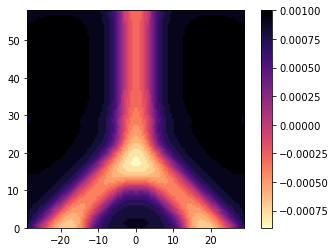

In [24]:
plt.figure()
plt.imshow(np.rot90(Z), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar();

Text(0.5, 1.0, 'V(x,y) - V(-x,y)')

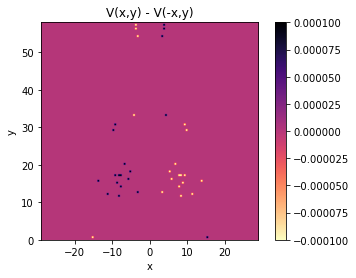

In [25]:
plt.imshow((np.rot90(Z[::-1,:])-np.rot90(Z)), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("V(x,y) - V(-x,y)")

#### Plot the potential across (x, z) that slices at [y = ? nm]

In [26]:
import tinyarray as ta
import math

grid = np.array(list(clean_potential.keys()))
unique_y = np.unique(grid[:, 1])
chosen_y_coords = unique_y[np.multiply(unique_y >= 5 * a, unique_y <= 20*a)]

grid = np.array(list(clean_potential.keys()))
total_potential = []

coordinates = grid[grid[:, 1] == chosen_y_coords[0]]
for i in chosen_y_coords[1:]:
    coordinates = np.append(coordinates, grid[grid[:, 1] == i], axis = 0)
    
for element in coordinates:
    total_potential.append(clean_potential[ta.array(element)])
    
    
filter_nan = list(map(lambda x: False if math.isnan(x) else True, total_potential))
total_potential = np.array(total_potential)[filter_nan]
coordinates = coordinates[filter_nan]

grid = (coordinates / a) * 10

#### Plot the grid across (x, z) plane that slices y at [y = ? nm]

Text(0, 0.5, 'Z [nm]')

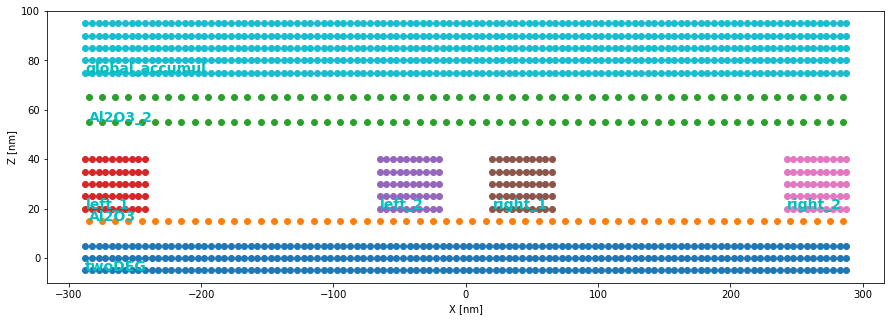

In [27]:
def filter_indices(points, minimum, maximum):
    data = np.unique(points[:, 1])
    chosen_y_coords = data[np.multiply(data >= minimum, data <= maximum)]
    if len(chosen_y_coords):
        return points[:, 1] == chosen_y_coords[0]
    else:
        return []
    
grid = grid_points.copy()

voltage_regions = {}
for key, indices in poisson_system.regions.voltage.tag_points.items():
    filtered_indices = filter_indices(grid[indices], 5, 20)
    voltage_regions[key] = indices[filtered_indices]
    
charge_regions = {}
for key, indices in poisson_system.regions.charge.tag_points.items():
    if key not in ['air', 'charge_default']:
        filtered_indices = filter_indices(grid[indices], 5, 20)
        charge_regions[key] = indices[filtered_indices]
        
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

for name, indices in charge_regions.items():
    points = grid_points[indices][:, [0, 2]] * 10
    ax.scatter(points[:, 0], points[:, 1])
    if len(points)!= 0:    
        ax.annotate(name, points[0], c = 'c', alpha = 1.0, fontsize = 14,
                           fontweight = 'bold')
            
for name, indices in voltage_regions.items():
    points = grid_points[indices][:, [0, 2]] * 10
    ax.scatter(points[:, 0], points[:, 1])
    if len(points)!= 0:    
        ax.annotate(name, points[0], c = 'c', alpha = 1.0, fontsize = 14,
                           fontweight = 'bold')

ax.set_xlabel('X [nm]')
ax.set_ylabel('Z [nm]')

#### Build kwant object

In [28]:
# Build kwant system

R_a = R*a
width_a = width*a
l = 150 * a
w = 7 * a
boundaries = [xmin, xmax, ymin, ymax, min(grid_points[:, 2]), max(grid_points[:, 2])]
boundaries = np.array(boundaries) * a

geometry ={'nw_l': l, 'nw_w': w,
           's_w': boundaries[1] - boundaries[0],
           's_l': boundaries[3] - boundaries[2],
           'centers':[[-R_a+width_a/np.sqrt(2), 0],
                      [-(-R_a+width_a/np.sqrt(2)), 0], 
                      [0,boundaries[3]+l-a]
                     ]
          }

In [29]:
%%time

trijunction, f_params = finite_system(**geometry)
trijunction = trijunction.finalized()

CPU times: user 274 ms, sys: 6.02 ms, total: 280 ms
Wall time: 276 ms


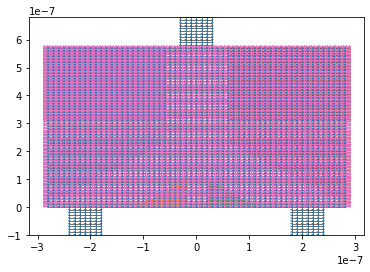

In [30]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-10*a, boundaries[3]+10*a)
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

for name, indices in voltage_regions.items():
    grid_to_plot = a*grid_points[indices][:, [0, 1]]
    ax.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)


### Optimal phases

In [36]:
solver = sl.general_solver(geometries=[[trijunction, f_params]],
                           n=20,
                           base_parameters=params,
                           eigenvecs=False)


def wrap(arg):
    return solver(*arg)

### Left-Right coupling

In [62]:
%%time
with Cluster(options) as cluster:
    cluster.scale(10)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/a3df0d7231434aef8afd6e4ff5cb5d1d/status
CPU times: user 21.5 s, sys: 659 ms, total: 22.2 s
Wall time: 2min 28s


In [63]:
spectra, couplings, wfs, peaks, widths = tl.coupling_data(result, n=20)

In [81]:
LR_phase = phis[peaks[0]]
LR_spectra = spectra
LR_couplings = couplings

Text(81.0, 0.5, '$E[\\mu eV]$')

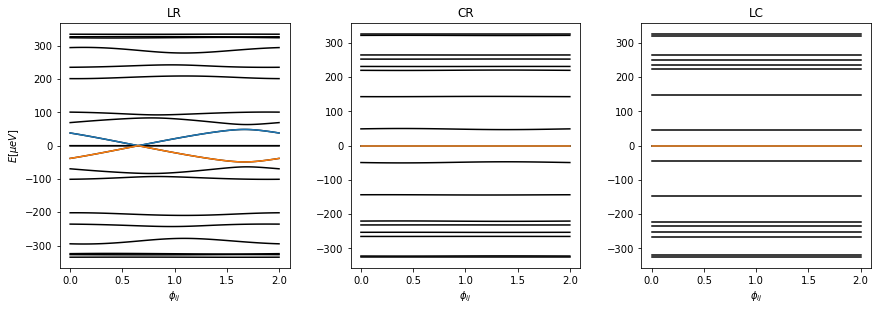

In [118]:
titles = ['LR', 'CR', 'LC']
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.tight_layout(w_pad=3)
phis = np.linspace(0, 2, 100)
spectra = [LR_spectra[0], LC_spectra[1], CR_spectra[2]]
couplings = [LR_couplings[0], LC_couplings[1], CR_couplings[2]]
for i in range(3):
    
    for level in spectra[i].T:
        ax[i].plot(phis, 1e6*level, c='black')
    ax[i].plot(phis, 1e6*couplings[i])
    ax[i].plot(phis, -1e6*couplings[i])
    #ax[i].vlines(x=max_phis[i], ymin=-100, ymax=100)
    ax[i].set_xlabel(r'$\phi_{ij}$')
    ax[i].set_title(titles[i])
ax[0].set_ylabel(r'$E[\mu eV]$')

In [38]:
import pickle

In [39]:
with open("/home/tinkerer/trijunction-design/data/optimal_phase.pkl", 'rb') as infile:
    optimal_phase = pickle.load(infile)

In [41]:
optimal_phase = optimal_phase * np.pi

#### Spectrum as a function of gate voltages

In [42]:
from scipy import sparse

In [43]:
poisson_params = {
    'poisson_system': poisson_system,
    'linear_problem': linear_problem,
    'site_coords': site_coords,
    'site_indices': site_indices,
}    

crds = site_coords
grid_spacing = grid_spacing_twoDEG
offset = crds[0]%grid_spacing

kwant_params = {
    'offset': offset,
    'grid_spacing': a,
    'finite_system_object': trijunction,
    'finite_system_params_object': f_params,
    
}


In [90]:
def spectrum_f_voltages(
    kwant_params,
    general_params,
    potential,
    no_of_eigenvalues = 6,
    return_eigenvecs = False,
    phis = [0, 0],    
):
    kp = kwant_params
    
    general_params.update(potential=potential)
    

    general_params['phi1'] = phis[0]
    general_params['phi2'] = phis[1]
    
    ham_mat = kp['finite_system_object'].hamiltonian_submatrix(
        sparse=True, params=kp['finite_system_params_object'](**general_params))
    
    if return_eigenvecs:
        evals, evecs = sl.sort_eigen(sparse.linalg.eigsh(ham_mat.tocsc(), k=no_of_eigenvalues, sigma = 0))
        
        return evals, evecs
    else:
        evals = np.sort(
            sparse.linalg.eigsh(ham_mat.tocsc(), k = no_of_eigenvalues, sigma = 0,
                                return_eigenvectors = return_eigenvecs)
        )
        evecs = []
        
        return evals

In [91]:
voltage_dict = {'left' : -5e-3, 
                'right' : -5e-3, 
                'top' : -5e-3, 
                'back' : 35e-3}

In [92]:
for i in range(1, 3):
    voltages['left_'+str(i)] = voltage_dict['left']
    voltages['right_'+str(i)] = voltage_dict['right']
    voltages['top_'+str(i)] = voltage_dict['top']
    
voltages['global_accumul'] = voltage_dict['back']

In [93]:
centers = np.array(geometry['centers']) / a
nw_l = geometry['nw_l'] / a
nw_w = geometry['nw_w'] / a

depletion_regions  = {'left': np.array(((centers[0][0] - nw_w /2, centers[0][1]),
                              (centers[0][0] + nw_w /2, centers[0][1])), dtype = 'float32'),
                      'right': np.array(((centers[1][0] - nw_w /2, centers[1][1]),
                               (centers[1][0] + nw_w /2, centers[1][1])), dtype = 'float32'),
                     'top':   np.array(((centers[2][0] - nw_w /2, centers[2][1] - nw_l),
                              (centers[2][0] + nw_w /2, centers[2][1] - nw_l)), dtype = 'float32')}

#### Region to be depleted closer to nanowire which must be disconnected from the cavity

In [94]:
grid = poisson_system.grid.points.astype('float32')

In [95]:
voltage_regions = poisson_system.regions.voltage.tag_points

In [96]:
twodeg_grid = site_indices
twodeg_grid_monolayer = twodeg_grid[grid[twodeg_grid][:, 2] == np.unique(grid[twodeg_grid][:, 2])[0]]

In [97]:
def depletion_points(grid, monolayer, boundary):
    Y = np.argmin(np.abs((grid[monolayer][:, 1] - boundary[0, 1])))
    X = grid[monolayer][:, 1] == grid[monolayer[Y]][1]
    point_indices = np.multiply(grid[monolayer[X]][:, 0] > boundary[0, 0], 
                                grid[monolayer[X]][:, 0] < boundary[1, 0])
    
    return monolayer[X][point_indices]

In [142]:
indices = depletion_points(grid, twodeg_grid_monolayer, depletion_regions['top'])
dep_indices = np.hstack(list(map(lambda x: np.argwhere(twodeg_grid == x), indices)))

indices = depletion_points(grid, twodeg_grid_monolayer, depletion_regions['left'])
acc_indices = [np.hstack(list(map(lambda x: np.argwhere(twodeg_grid == x), indices)))]

indices = depletion_points(grid, twodeg_grid_monolayer, depletion_regions['right'])
# acc_indices = np.hstack(np.concatenate((acc_indices, 
#                              np.hstack(list(map(lambda x: np.argwhere(twodeg_grid == x), 
#                                                 indices))))))

acc_indices.append(np.hstack(list(map(lambda x: np.argwhere(twodeg_grid == x), 
                                                indices))))

In [400]:
def gate_tuner(x, *argv):
    
    voltages = {}
    
    for i in range(1, 3):
        voltages['left_'+str(i)] = x[0]
        voltages['right_'+str(i)] = x[1]
        voltages['top_'+str(i)] = x[2]
    
    voltages['global_accumul'] = x[3]
    
    poisson_params, kwant_params, general_params,  = argv[:3]
    dep_points, acc_points = argv[3:5]
    
    pp = poisson_params
    kp = kwant_params
    
    charges = {}
    potential = gate_potential(
            pp['poisson_system'],
            pp['linear_problem'],
            pp['site_coords'],
            pp['site_indices'],
            voltages,
            charges,
            offset = kp['offset'],
            grid_spacing = kp['grid_spacing']
        )
    
    potential.update((x, y*-1) for x, y in potential.items())
    
    potential_array = np.array(list(potential.values()))

    dep_potential = potential_array[dep_points]
    acc_potential = [potential_array[points] for points in acc_points]
    barrier_cost, accumulation_cost = [0.0], [0.0]
    
    if np.any(dep_potential > general_params['mus_nw'][0]): 
        print("Disconnected")
    else: 
        barrier_cost = np.hstack(dep_potential - general_params['mus_nw'][0])
        print(sum(np.abs(barrier_cost)))
    
    if np.all(np.hstack(acc_potential) < general_params['mus_nw'][0]): 
        print("Connected")
    else: 
        accumulation_cost = np.hstack(sum(acc_potential) - general_params['mus_nw'][0])
        print(sum(np.abs(accumulation_cost)))


    pp = poisson_params
    kp = kwant_params
    
    charges = {}
    potential = gate_potential(
            pp['poisson_system'],
            pp['linear_problem'],
            pp['site_coords'][:, [0, 1]],
            pp['site_indices'],
            voltages,
            charges,
            offset = kp['offset'][[0, 1]],
            grid_spacing = kp['grid_spacing']
        )
    
    potential.update((x, y*-1) for x, y in potential.items())

    spectrum_values = spectrum_f_voltages(
                        kwant_params,
                        general_params,
                        potential,
                        no_of_eigenvalues = 6,
                        return_eigenvecs = False,
                        phis = [optimal_phase[0], np.pi]
                    )
    
    coupling_cost = spectrum_values[-2]
    
    
    print(coupling_cost)
    
    return sum(np.hstack((np.abs(barrier_cost), 
                      np.abs(accumulation_cost), 
                      -1 * coupling_cost))) # -1 to maximize the couplings
    

In [401]:
params = pm.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)

In [402]:
args = (poisson_params, kwant_params, params, dep_indices, acc_indices)
initial_condition = [-5e-3, -5e-3, -5e-3, 35e-3]

In [403]:
from scipy.optimize import minimize

In [404]:
%%time

sol1 = minimize(
            gate_tuner,
            initial_condition,
            args=args,
    method = 'trust-constr',
            options = {'disp': True, 'verbose': 2 }
        )

0.08169209975873866
Connected
4.439782991593717e-08
0.08169209901571944
Connected
4.43977970243454e-08
0.08169209901574889
Connected
4.439825174534771e-08
0.08169193664198124
Connected
4.439815545179756e-08
0.08169214377222891
Connected
4.4397781452525345e-08
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +8.1692e-02 | 1.00e+00 | 1.09e+01 | 0.00e+00 |
Disconnected
2.2348296123653792
1.854983491393385e-07
Disconnected
2.2348297592818938
1.8549834913919147e-07
Disconnected
2.234829759254964
1.8549834913921032e-07
Disconnected
2.2348296166698307
1.8549834910201575e-07
Disconnected
2.234829731487344
1.8549834912684293e-07
|   2   |  10   |   1   | +8.1692e-02 | 5.00e-01 | 1.09e+01 | 0.00e+00 |
Disconnected
1.0107598694999733
1.8822827016665327e-07
Disconnected
1.0107600164164872
1.882282701659744e-07
Disconnected
1.0107600163895578
1.8822827016596442e-07
Disconnected

In [405]:
x = sol1.x
for i in range(1, 3):
    voltages['left_'+str(i)] = x[0]
    voltages['right_'+str(i)] = x[1]
    voltages['top_'+str(i)] = x[2]

voltages['global_accumul'] = x[3]

In [406]:
voltages

{'left_1': -0.005983167320436252,
 'left_2': -0.005983167320436252,
 'right_1': -0.0048146448767345815,
 'right_2': -0.0048146448767345815,
 'top_1': -0.06584064336605097,
 'top_2': -0.06584064336605097,
 'global_accumul': 0.01968090390358677}

In [407]:
charges = {}
potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset = offset[[0, 1]],
        grid_spacing = kwant_params['grid_spacing']
    )

potential.update((x, y*-1) for x, y in potential.items())

In [408]:
params.update(potential=potential)

In [409]:
f_mu = f_params(**params)['mu']

In [410]:
def plot_f_mu(i):
    x, y = trijunction.sites[i].pos
    return f_mu(x, y)

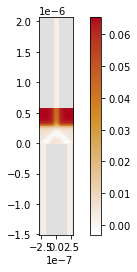

In [411]:
# fig, ax = plt.subplots()
cax = kwant.plotter.map(trijunction, plot_f_mu, colorbar = True)
# fig.colorbar()
# ax.set_ylim(-1e-7, 9e-7)

In [412]:
%%time

eigval, eigvec = spectrum_f_voltages(
                        kwant_params,
                        params,
                        potential,
                        no_of_eigenvalues = 6,
                        return_eigenvecs = True,
                        phis = [optimal_phase[0], np.pi]
                    )

CPU times: user 1.02 s, sys: 28 ms, total: 1.05 s
Wall time: 1.04 s


In [413]:
ham_mat = trijunction.hamiltonian_submatrix(
    sparse=True, params=f_params(**params)
)

In [414]:
evals, evecs = sl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=6, sigma = 0.0))

In [415]:
evals

array([-2.37602379e-06, -2.28580462e-07, -1.03139694e-09,  1.03139694e-09,
        2.28580462e-07,  2.37602379e-06])

In [416]:
density = kwant.operator.Density(trijunction, np.eye(4))

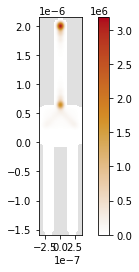

In [417]:
kwant.plotter.density(trijunction, density(evecs[-2]));

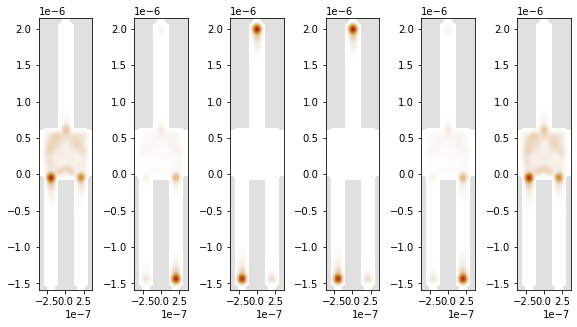

In [399]:
fig, ax = plt.subplots(1, 6, figsize = (10, 5))
for i in range(6):
    kwant.plotter.density(trijunction, density(eigvec[i]), ax = ax[i]);